In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import sqlite3

In [3]:
# This creates a TS, where the distribution changes at different points deppending on a provided list of distribution shifts.
def Create_TimeSeries(s, dist_shifts):
    n = s//len(dist_shifts)
    m = s%len(dist_shifts)

    final = np.array([])
    
    for i in range(len(dist_shifts)-1):
        Y = abs(np.random.normal(dist_shifts[i][0], dist_shifts[i][1], n))
        final = np.concatenate((final, Y))
    
    final = np.concatenate((final, abs(np.random.normal(dist_shifts[-1][0], dist_shifts[-1][1], n+m))))
    
    return final

In [23]:
# Here we will just look at a simple random walk.

p = 0.5
pdist = [1-p, p]
steps = [-1, 1]

datapoints = 10
seq_length = 300

output_label_tuples = []

dist_shift = [(0, 1), (-5, 1), (0, 10), (-10, 1)]
#dist_shift = [(0,1), (2,0)]
#dist_shift = [((-1**x) * 100, 100) if x%5==0 else (0, 0) for x in range(30)]

for _ in range(datapoints):
    X =  np.random.choice(steps, size=seq_length, p=pdist)
    Y = Create_TimeSeries(seq_length, dist_shift)
    T = np.cumsum(X*Y)
    
    input_data = T[:-1]
    labels_data = T[1:]

    output_label_tuples.append((input_data, labels_data))

In [24]:
train_Output = output_label_tuples

In [12]:
def Model(x):
    add = 0.00
    return x #+ (np.random.choice(steps, len(x), p=[0.5-add, 0.5+add]) * abs(np.random.normal(0, 1, len(x))))

Would It not just be better to take the previous value as the thing -> this woudl make more sense but the whole of this technique is that it that should on any model. This is a good test for your models which you have been making as this is a sense where it is impossible to get any on the model.

inital_window_size = 50
alpha = 0.3
orignal_alpha = alpha 

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    Q = np.quantile(scores[:t], alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    
def l(B, theta):
    return (orignal_alpha * (B - theta)) - min(0, (B - theta))
    

# We have 240 elememts we want a decent approximation of the quantile. So we will start at.



total_coverage_list = []


# The hyperparameters for the DtACI model.
sigma = 0.1
nu = 0.1

e = 2.71 #np.e

for m, (x, y) in enumerate(train_Output):
    break
    # Initialising the gamma candidates and the weights.
    candiate_gamma = [0.01, 0.02, 0.03, 0.05, 0.1]
    candiate_alpha = [[0.1, 0.2, 0.3, 0.4, 0.5]]
    gamma_weights = [[1.0 for _ in candiate_gamma]]
    
    error_list = []
    Coverage_list = []
    alpha_list = []
    
    alpha_error_list = []
    
    xpred = Model(x)
    # Calculating the scores at each time step
    All_scores = (abs(y - xpred))/abs(xpred)


    # New thing to keep track of.
    
    for i in range(20, len(All_scores)):
        # The probability of each gamma from the weights from stept.

        Wt = sum(gamma_weights[-1])
        gamma_probabilites = [w/Wt for w in gamma_weights[-1]]
        
        
        # Choosing a alpha from the probabilites from the gamma candidates. Then calculating the coverage.
        chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
        alpha_list.append(chosen_alpha_t)
        Coverage_t = C_t(chosen_alpha_t, All_scores, xpred[i], i)
        Coverage_list.append(Coverage_t)

        # Updating the weights.
        temp = [gamma_weights[j] * np.exp(-nu * l(y[i], candiate_alpha[-1][j])) for j in range(len(candiate_gamma))]
        sumW, lenW = sum(temp), len(temp)
        gamma_weights.append([(w*(1-sigma)) + sumW*(sigma/lenW) for w in temp])

        # Calculating the coverage and error at each time step, for different alpha values.
        alphai_errors = [err_t(y[i], C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]]
        alpha_error_list.append(alphai_errors)

        err_true = err_t(y[i], C_t(chosen_alpha_t, All_scores, xpred[i], i))
        error_list.append(err_true)

        # Updating the alpha values.
        candiate_alpha.append([alpha_i + (gamma_c * (orignal_alpha - alpha_i_err)) for alpha_i, alpha_i_err, gamma_c in zip(candiate_alpha[-1], alphai_errors, candiate_gamma)])
        
        # Mustgo back and check what beta is.
        



    
    coverage = 1 - pd.Series(error_list).mean()
    total_coverage_list.append(coverage)
    
    if m<10:
        fig, axs = plt.subplots(2, 2, figsize=(30, 10))
        
        print(error_list)
        axs[0][0].plot(1 - pd.Series(error_list).rolling(50).mean())
        axs[0][0].axhline(coverage, color='r', linestyle='--')
        axs[0][0].set_title('Coverage')
        
        axs[0][1].plot([ele[0] for ele in Coverage_list], label='Lower')
        axs[0][1].plot([ele[1] for ele in Coverage_list], label='Upper')
        axs[0][1].plot(y[20:])
        axs[0][1].set_title('Prediction')
        axs[0][1].legend()

        axs[1][0].plot([ele[1]-ele[0] for ele in Coverage_list], label='Distance')
        axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in Coverage_list]), color='r', linestyle='--')
        axs[1][0].legend()
        axs[1][0].set_title('Distance between upper and lower bounds')

        axs[1][1].plot(alpha_list)
        axs[1][1].set_title('Alpha')


        plt.show()



#print('The average coverage is', np.mean(total_coverage_list))

# Would be useful to know the average distance between the upper and lower predictions.
#average_distance = np.mean([ele[1] - ele[0] for ele in Coverage_list])
#print('The average distance between the upper and lower predictions is', average_distance)


# THIS code is inefficent as it tracks the weights.
inital_window_size = 50
alpha = 0.3
orignal_alpha = alpha 

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[:t], alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    
def l(B, theta):
    return (orignal_alpha * (B - theta)) - min(0, (B - theta))



l_vec = np.vectorize(l)
    

# We have 240 elememts we want a decent approximation of the quantile. So we will start at.



total_coverage_list = []


# The hyperparameters for the DtACI model.
sigma = 0.5
nu = 0.01



for m, (x, y) in enumerate(train_Output[0:5]):
    # Initialising the gamma candidates and the weights.
    candiate_gamma = np.array([0.01, 0.02, 0.03, 0.05, 0.1])
    candiate_alpha = np.array([[orignal_alpha for _ in candiate_gamma]])
    gamma_weights = np.array([[1.0 for _ in candiate_gamma]])
    
    error_list = []
    Coverage_list = []
    alpha_list = []
    
    alpha_error_list = []
    
    xpred = Model(x)
    # Calculating the scores at each time step
    All_scores = (abs(y - xpred))/abs(xpred)


    # New thing to keep track of.
    
    for i in range(20, len(All_scores)):
        # The probability of each gamma from the weights from stept.
        Wt = sum(gamma_weights[-1])
        gamma_probabilites = gamma_weights[-1]/Wt
        
        # Choosing a alpha from the probabilites from the gamma candidates. Then calculating the coverage.
        chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
        alpha_list.append(chosen_alpha_t)
        Coverage_t = C_t(chosen_alpha_t, All_scores, xpred[i], i)
        Coverage_list.append(Coverage_t)

        # We need to calculate B_t, which is the smallest value such that the obseved value is within the interval.
        for possi in np.linspace(0, 1, 1000):
            Cpossi= C_t(possi, All_scores, xpred[i], i)
            if Cpossi[0] < y[i] < Cpossi[1]:
                B_t = possi
                break

        
        # Updating the weights.
        new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1]))
        sumW, lenW = sum(new_weights), len(new_weights)
        final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
        gamma_weights = np.vstack((gamma_weights, final_weights))

        # Calculating the coverage and error at each time step, for different alpha values.
        alphai_errors = np.array([err_t(y[i], C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
        alpha_error_list.append(alphai_errors)

        err_true = err_t(y[i], C_t(chosen_alpha_t, All_scores, xpred[i], i))
        error_list.append(err_true)

        # Updating the alpha values.
        new_alphas = candiate_alpha[-1] + (candiate_gamma * (orignal_alpha - alphai_errors))
        candiate_alpha = np.vstack((candiate_alpha, new_alphas))

        #plt.plot(alpha_list)
        #plt.show()
        
        # Mustgo back and check what beta is.
    
    coverage = 1 - pd.Series(error_list).mean()
    total_coverage_list.append(coverage)
    
    if m<10:
        fig, axs = plt.subplots(2, 2, figsize=(30, 10))
        
        print(error_list)
        axs[0][0].plot(1 - pd.Series(error_list).rolling(5).mean())
        axs[0][0].axhline(coverage, color='r', linestyle='--')
        axs[0][0].set_title('Coverage')
        
        axs[0][1].plot([ele[0] for ele in Coverage_list], label='Lower')
        axs[0][1].plot([ele[1] for ele in Coverage_list], label='Upper')
        axs[0][1].plot(y[20:])
        axs[0][1].set_title('Prediction')
        axs[0][1].legend()

        axs[1][0].plot([ele[1]-ele[0] for ele in Coverage_list], label='Distance')
        axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in Coverage_list]), color='r', linestyle='--')
        axs[1][0].legend()
        axs[1][0].set_title('Distance between upper and lower bounds')

        axs[1][1].plot(alpha_list)
        axs[1][1].set_title('Alpha')


        plt.show()



print('The average coverage is', np.mean(total_coverage_list))

# Would be useful to know the average distance between the upper and lower predictions.
average_distance = np.mean([ele[1] - ele[0] for ele in Coverage_list])
print('The average distance between the upper and lower predictions is', average_distance)

This one is working but is not very accurate. Likley still a mistake in it.

Havent really been able to replicate results. Likely still an error somewhere, it performs way worse if not choosing randomly. Should compare directly to the simple method.

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


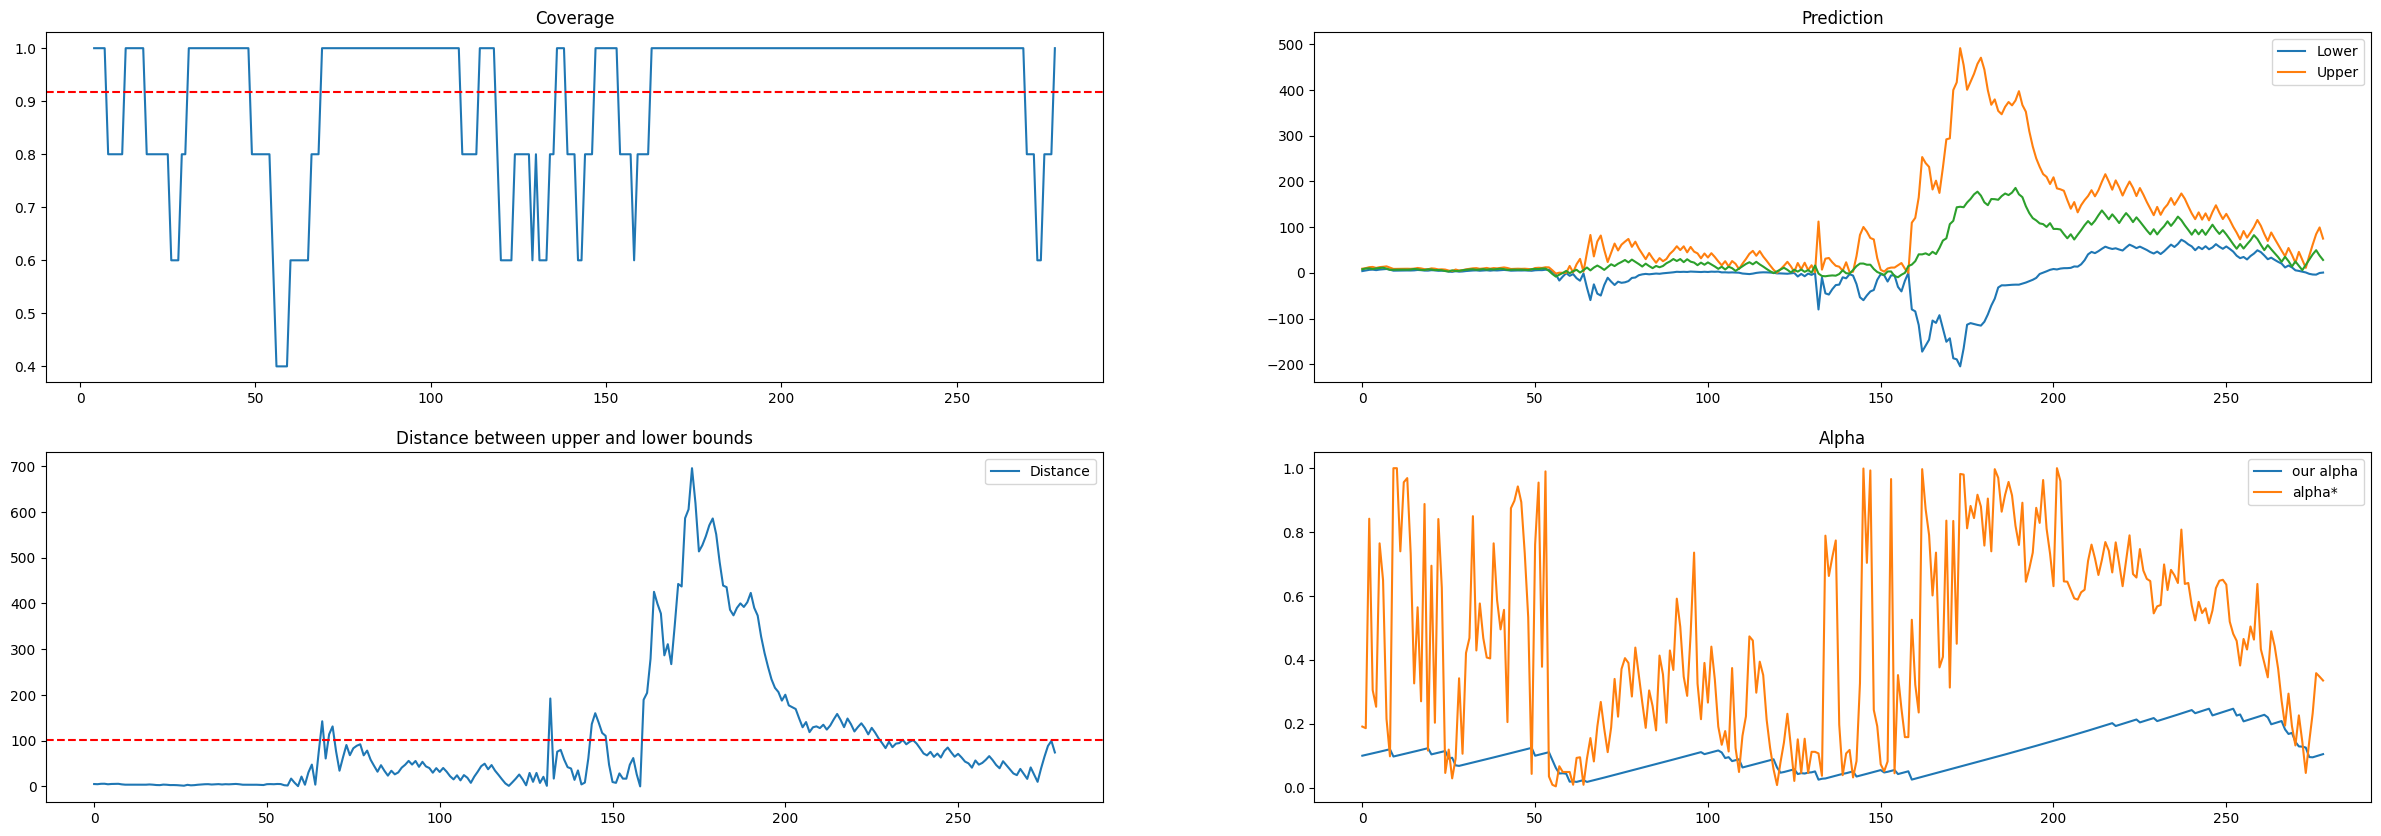

KeyboardInterrupt: 

In [34]:
inital_window_size = 50
alpha = 0.1
orignal_alpha = alpha 

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[:t], 1 - alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    
def l(B, theta):
    return (orignal_alpha * (B - theta)) - min(0, (B - theta))
l_vec = np.vectorize(l)
    
total_coverage_list = []


# The hyperparameters for the DtACI model.
sigma = 0.05
nu = 0.1

for m, (x, y) in enumerate(train_Output[0:5]):
    # Initialising the gamma candidates and the weights.
    candiate_gamma = np.array([0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128])
    candiate_alpha = np.array([[orignal_alpha for _ in candiate_gamma]])
    gamma_weights = np.array([np.random.random() for _ in candiate_gamma])
    
    error_list = []
    Coverage_list = []
    alpha_list = []
    alpha_error_list = []
    B_t_list = []
    
    xpred = Model(x)
    
    # Calculating the scores at each time step
    All_scores = (abs(y - xpred))/abs(xpred)


    for i in range(20, len(All_scores)):
        # The probability of each gamma from the weights from step t.
        Wt = gamma_weights.sum()
        gamma_probabilites = gamma_weights/Wt
        
        # Choosing a alpha from the probabilites from the gamma candidates. Then calculating the coverage.
        #chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
        chosen_alpha_t = sum(gamma_probabilites * candiate_alpha[-1])
        alpha_list.append(chosen_alpha_t)
        
        Coverage_t = C_t(chosen_alpha_t, All_scores, xpred[i], i)
        Coverage_list.append(Coverage_t)
        err_true = err_t(y[i], Coverage_t)
        error_list.append(err_true)

        # TIME FRONTIER -------

        # B is the sig level, we want the smallest one so that y is just in it.
        for possi in abs(np.linspace(-1, 0, 1000)):
            Cpossi= C_t(possi, All_scores, xpred[i], i)
            if Cpossi[0] < y[i] < Cpossi[1]:
                B_t = possi
                break
        
        B_t_list.append(B_t)
        
        
        # Updating the weights.
        new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1]))
        sumW, lenW = sum(new_weights), i
        final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
        gamma_weights = final_weights

        # Calculating the coverage and error at each time step, for different alpha values.
        alphai_errors = np.array([err_t(y[i], C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
        alpha_error_list.append(alphai_errors)


        # Updating the alpha values.
        new_alphas = candiate_alpha[-1] + (candiate_gamma * (orignal_alpha - alphai_errors))
        candiate_alpha = np.vstack((candiate_alpha, new_alphas))

    
    # Making the plots

    coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
    total_coverage_list.append(coverage)
    
    if m<10:
        fig, axs = plt.subplots(2, 2, figsize=(30, 10))
        
        print(error_list)
        axs[0][0].plot(1 - pd.Series(error_list).rolling(5).mean())
        axs[0][0].axhline(coverage, color='r', linestyle='--')
        axs[0][0].set_title('Coverage')
        
        axs[0][1].plot([ele[0] for ele in Coverage_list], label='Lower')
        axs[0][1].plot([ele[1] for ele in Coverage_list], label='Upper')
        axs[0][1].plot(y[20:])
        axs[0][1].set_title('Prediction')
        axs[0][1].legend()

        axs[1][0].plot([ele[1]-ele[0] for ele in Coverage_list], label='Distance')
        axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in Coverage_list]), color='r', linestyle='--')
        axs[1][0].legend()
        axs[1][0].set_title('Distance between upper and lower bounds')

        axs[1][1].plot(alpha_list,label='our alpha')
        axs[1][1].plot(B_t_list, label='alpha*')
        axs[1][1].legend()
        axs[1][1].set_title('Alpha')


        plt.show()



print('The average coverage is', np.mean(total_coverage_list))

# Would be useful to know the average distance between the upper and lower predictions.
average_distance = np.mean([ele[1] - ele[0] for ele in Coverage_list])
print('The average distance between the upper and lower predictions is', average_distance)

In [29]:
print(candiate_alpha)
print(alpha_error_list) # There is an instance when the alpha error list is not all the same. 

[[0.3    0.3    0.3    ... 0.3    0.3    0.3   ]
 [0.3003 0.3006 0.3012 ... 0.3096 0.3192 0.3384]
 [0.3006 0.3012 0.3024 ... 0.3192 0.3384 0.3768]
 ...
 [0.3071 0.3142 0.3204 ... 0.7192 0.6904 0.6968]
 [0.3074 0.3148 0.3216 ... 0.7288 0.7096 0.7352]
 [0.3077 0.3154 0.3228 ... 0.7384 0.7288 0.7736]]
[array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array(

In [15]:
# inital_window_size = 50
# orignal_alpha = 0.3

# # This function predicts a range of Y_t at the alpha level. By using alpha_t.
# def C_t(alpha_t, scores, sigma_t, t):
#     alpha_t = min(1, max(0, alpha_t))
#     Q = np.quantile(scores[:t], 1 - alpha_t)
#     positve_v = (sigma_t) + (abs(sigma_t) * Q)
#     negative_v = (sigma_t) - (abs(sigma_t) * Q)
#     return negative_v, positve_v

# # This function returns 1 if the prediction lies in the interval, 0 otherwise.
# def err_t(Y_t, C_t):
#     if C_t[0] < Y_t < C_t[1]:
#         return 0
#     else:
#         return 1
    
# def l(B, theta):
#     return (orignal_alpha * (B - theta)) - min(0, (B - theta))
# l_vec = np.vectorize(l)
    
# total_coverage_list = []


# # The hyperparameters for the DtACI model.
# sigma = 0.5
# nu = 0.3

# for m, (x, y) in enumerate(train_Output[0:1]):
#     error_list = []
#     Coverage_list = []
#     alpha_list = []
    
#     alpha_error_list = []

#     # The first x is the guess for the first y.

#     # Initialising the gamma candidates and the weights.

#     # These are the expert gammas.
#     candiate_gamma = np.array([0.01, 0.02, 0.03, 0.05, 0.1])
#     # We are essentialy running ACI multiple times and will evaluate the performance of each gamma.
#     candiate_alpha = np.array([[orignal_alpha for _ in candiate_gamma]])
#     # The weights for each gamma.
#     gamma_weights = np.array([1 for _ in candiate_gamma])

#     for i in range(0, len(x)):
#         # The probabilites at time t.
#         Wt = gamma_weights.sum()
#         gamma_probabilites = gamma_weights/Wt
        
#         ## We will remove the randomness
#         chosen_alpha_t = sum(gamma_probabilites * candiate_alpha[-1])
#         alpha_list.append(chosen_alpha_t)

#         Coverage_t = C_t(chosen_alpha_t, x, x[i], i)
#         Coverage_list.append(Coverage_t)
#         err_true = err_t(y[i], Coverage_t)
#         error_list.append(err_true)
#         # TIME FRONTEIR WE HAVE CHOSEN ALPHA SO CAN ACCSESS THE TRUE Y.
        

#         # We need to calculate B_t, which is the smallest value such that the obseved value is within the interval.
#         for possi in np.linspace(0, 1, 1000):
#             Cpossi= C_t(possi, x, x[i], i)
#             if Cpossi[0] < y[i] < Cpossi[1]:
#                 B_t = possi
#                 break

        
#         # Updating the weights.
#         new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1]))
#         sumW, lenW = sum(new_weights), i
#         final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
#         gamma_weights = final_weights

#         # Calculating the coverage and error at each time step, for different alpha values.
#         alphai_errors = np.array([err_t(y[i], C_t(alpha_i, x, x[i], i)) for alpha_i in candiate_alpha[-1])
#         alpha_error_list.append(alphai_errors)


#         # Updating the alpha values.
#         new_alphas = candiate_alpha[-1] + (candiate_gamma * (orignal_alpha - alphai_errors))
#         candiate_alpha = np.vstack((candiate_alpha, new_alphas))

#         #plt.plot(alpha_list)
#         #plt.show()
        
#         # Mustgo back and check what beta is.



    
    
    
#     # Calculating the scores at each time step
